<a href="https://colab.research.google.com/github/pjjongho/Colab_AD/blob/main/Unbalanced%20Character%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Chapter 07]**  
**┗ 밸런스 이상 캐릭터 탐지**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「Data 전처리 및 EDA」
* 🥈Session 2 - 「캐릭터 특성 파악하기」
* 🥇Session 3 - 「이상 탐지 모델링」

In [2]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir("/content/drive/MyDrive/")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive'

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 👾

```
A사는 유명한 캐릭터 게임을 만든는 회사다. 해당 게임은 팀배틀 AOS 게임이다. 10명의 플레이어가 두 팀으로 나뉘어 각자의 캐릭터를 골라 조종하고  
골 포인트 득점의 총합으로 승부를 가리는 규칙이다. 각 캐릭터는 특성에 따라 스테이터스를 보유하고 있다. 이 스테이터스의 밸런스가 적절해야 게임 전체에  
대한 플레이 밸런스가 유지되기 때문에 매우 중요한 영역이라고 할 수 있다. 현재 운영되고 있는 게임 캐릭터를 대상으로 밸런스가 양호한지 검토해보고자 한다.

```  

> **데이터 살펴보기**

* 게임 캐릭터 스테이터스 정보
* 데이터 명세 ⬇

|Column|Description|
|:---|:---|
|Name|캐릭터명|
|Description |설명|
|Role |역할|
|Ranged_or_Melee |근접/원거리 유형|
|UsageDifficulty |유저 난이도|
|Offense |공격력|
|Endurance |지구력|
|Mobility |이동력|
|Scoring |득점력|
|Support |지원력|





In [ ]:
# ▶ pd.set option
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

# ▶ Data read
df = pd.read_csv("chapter07_df.csv")
df.head()

,Name,Description,Role,Ranged_or_Melee,UsageDifficulty,Offense,Endurance,Mobility,Scoring,Support
0,Zoroark,Confound the competition with Zoroark’s speed ...,Speedster,Melee,Expert,3.5,1.5,4.0,2.0,0.5
1,Scizor,Test your mettle with this Melee All-Rounder c...,All-Rounder,Melee,Intermediate,4.5,2.5,4.5,2.5,1.0
2,Glaceon,Take the Glacial Stage with this sleet-footed ...,Attacker,Ranged,Intermediate,4.0,2.0,3.0,1.0,0.5
3,Tyranitar,Go on a rampage with this tyrannical Melee All...,All-Rounder,Melee,Intermediate,4.0,4.0,2.0,1.5,1.0
4,Dodrio,Prove that three heads are better than one wit...,Speedster,Melee,Expert,3.0,2.0,4.0,4.0,0.5



## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 캐릭터 밸런스 이상으로 게임 퀄리티 저하
▶ 신규 진입 유저 감소, 기존 유저 이탈 증가
```  

> **기대효과**

```
▶ 캐릭터 스테이터스 조정을 통해 게임 밸런스 조정
▶ 신규 진입 유저 증가, 기존 유저 이탈 방지
```

> **해결방안**

```
▶ 스테이터스 이상 캐릭터 탐지, 밸런스 조정을 통해 게임 정상화
▶ Session 1 🥉
 - Data 전처리 및 EDA
▶ Session 2 🥈
 - 캐릭터 특성 및 스테이터스 탐색하기
▶ Session 3 🥇
 - 이상 탐지 모델링 수행
```

> **성과측정**  

```
▶ 밸런스 조정 후 신규 유저 진입률 비교
▶ 밸런스 조정 후 기존 고객 이탈률 비교
```

> **현업적용**  

```
▶ 밸런스 이상 캐릭터 검출 후 밸런스 조정 검토
▶ 밸런스 조정 후 게임 업데이트 반영
```

> **주요 코드 미리 살펴보기**  

```
▶ Session 1 → sns.histplot()
▶ Session 2 → sns.distplot(), enumerate(), plt.subplots(), spider chart
▶ Session 3 → .reset_index(), .sort_values(['Role', 'all_stat'], ascending= [True, False])
```

## **🥉Session 1**  
**┗ Data 전처리 및 EDA**  
---

### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)

  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  

In [ ]:
# ▶ Data 형태 확인
# ▶ 44 row, 10 col로 구성됨
print('df :', df.shape)

df : (44, 10)


In [ ]:
# ▶ Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             44 non-null     object 
 1   Description      44 non-null     object 
 2   Role             44 non-null     object 
 3   Ranged_or_Melee  44 non-null     object 
 4   UsageDifficulty  44 non-null     object 
 5   Offense          44 non-null     float64
 6   Endurance        44 non-null     float64
 7   Mobility         44 non-null     float64
 8   Scoring          44 non-null     float64
 9   Support          44 non-null     float64
dtypes: float64(5), object(5)
memory usage: 3.6+ KB


In [ ]:
# ▶ Null 값 확인
print(df.isnull().sum())

Name               0
Description        0
Role               0
Ranged_or_Melee    0
UsageDifficulty    0
Offense            0
Endurance          0
Mobility           0
Scoring            0
Support            0
dtype: int64


In [ ]:
# ▶ Outlier 확인
df.describe()

,Offense,Endurance,Mobility,Scoring,Support
count,44.000000,44.000000,44.000000,44.000000,44.000000
mean,3.204545,2.545455,2.602273,2.306818,1.784091
std,1.030456,0.951243,0.955885,0.700630,1.432179
min,1.000000,1.500000,1.000000,1.000000,0.500000
25%,2.500000,1.875000,2.000000,1.875000,0.500000
50%,3.500000,2.250000,2.500000,2.500000,1.000000
75%,4.000000,3.125000,3.000000,2.625000,3.000000
max,4.500000,5.000000,5.000000,4.000000,4.500000


### · Data EDA
---
* 데이터 특성 파악을 위한 초기 탐색

In [ ]:
df.head()

,Name,Description,Role,Ranged_or_Melee,UsageDifficulty,Offense,Endurance,Mobility,Scoring,Support
0,Zoroark,Confound the competition with Zoroark’s speed ...,Speedster,Melee,Expert,3.5,1.5,4.0,2.0,0.5
1,Scizor,Test your mettle with this Melee All-Rounder c...,All-Rounder,Melee,Intermediate,4.5,2.5,4.5,2.5,1.0
2,Glaceon,Take the Glacial Stage with this sleet-footed ...,Attacker,Ranged,Intermediate,4.0,2.0,3.0,1.0,0.5
3,Tyranitar,Go on a rampage with this tyrannical Melee All...,All-Rounder,Melee,Intermediate,4.0,4.0,2.0,1.5,1.0
4,Dodrio,Prove that three heads are better than one wit...,Speedster,Melee,Expert,3.0,2.0,4.0,4.0,0.5


In [ ]:
# ▶ 총 캐릭터 수, 중복되는 캐릭터 X
df['Name'].value_counts()

Zoroark             1
Scizor              1
Cramorant           1
Mr. Mime            1
Venusaur            1
Lucario             1
Talonflame          1
Crustle             1
Snorlax             1
Charizard           1
Eldegoss            1
Greninja            1
Pikachu             1
Zeraora             1
Gardevoir           1
Blissey             1
Blastoise           1
Sylveon             1
Mamoswine           1
Greedent            1
Aegislash           1
Slowbro             1
Absol               1
Machamp             1
Hoopa               1
Glaceon             1
Tyranitar           1
Dodrio              1
Delphox             1
Clefable            1
Espeon              1
Buzzwole            1
Mew                 1
Duraludon           1
Wigglytuff          1
Azumarill           1
Tsareena            1
Dragonite           1
Trevenant           1
Alolan Ninetales    1
Cinderace           1
Garchomp            1
Gengar              1
Decidueye           1
Name: Name, dtype: int64

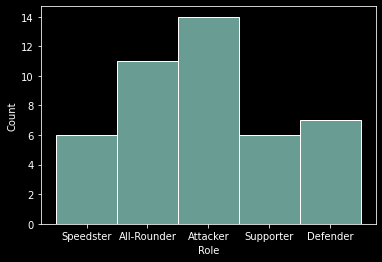

In [ ]:
# ▶ 캐릭터 역할
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['dark_background'])

sns.histplot(data = df['Role'], kde = False);

In [ ]:
df['Role'].value_counts()

Attacker       14
All-Rounder    11
Defender        7
Speedster       6
Supporter       6
Name: Role, dtype: int64

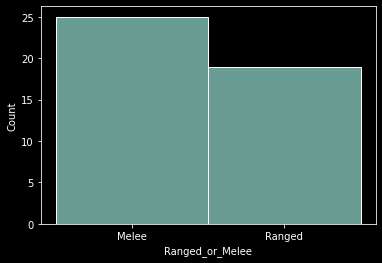

In [ ]:
# ▶ 캐릭터 공격 Type (Melee : 근접 / Ranged : 원거리)
sns.histplot(data = df['Ranged_or_Melee'], kde = False);

In [ ]:
df['Ranged_or_Melee'].value_counts()

Melee     25
Ranged    19
Name: Ranged_or_Melee, dtype: int64

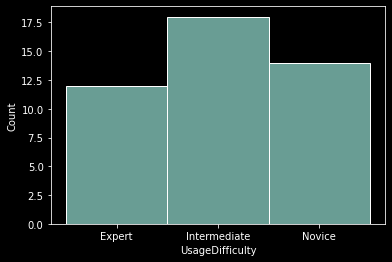

In [ ]:
# ▶ 사용자 난이도
sns.histplot(data = df['UsageDifficulty'], kde = False);

In [ ]:
df['UsageDifficulty'].value_counts()

Intermediate    18
Novice          14
Expert          12
Name: UsageDifficulty, dtype: int64

In [ ]:
pd.DataFrame(df.groupby(['Role','Ranged_or_Melee','UsageDifficulty'])['Name'].count())

Name
Role        Ranged_or_Melee UsageDifficulty      
All-Rounder Melee           Expert              3
                            Intermediate        5
                            Novice              3
Attacker    Ranged          Expert              2
                            Intermediate        7
                            Novice              5
Defender    Melee           Expert              1
                            Intermediate        2
                            Novice              2
            Ranged          Intermediate        2
Speedster   Melee           Expert              5
                            Novice              1
Supporter   Melee           Intermediate        1
                            Novice              2
            Ranged          Expert              1
                            Intermediate        1
                            Novice              1

## **🥈Session 2**  
**┗ 캐릭터 특성 파악하기**  
---

### · 스테이터스 이해 및 분포 확인
---

In [ ]:
# ▶ 데이터 확인
df.head()

,Name,Description,Role,Ranged_or_Melee,UsageDifficulty,Offense,Endurance,Mobility,Scoring,Support
0,Zoroark,Confound the competition with Zoroark’s speed ...,Speedster,Melee,Expert,3.5,1.5,4.0,2.0,0.5
1,Scizor,Test your mettle with this Melee All-Rounder c...,All-Rounder,Melee,Intermediate,4.5,2.5,4.5,2.5,1.0
2,Glaceon,Take the Glacial Stage with this sleet-footed ...,Attacker,Ranged,Intermediate,4.0,2.0,3.0,1.0,0.5
3,Tyranitar,Go on a rampage with this tyrannical Melee All...,All-Rounder,Melee,Intermediate,4.0,4.0,2.0,1.5,1.0
4,Dodrio,Prove that three heads are better than one wit...,Speedster,Melee,Expert,3.0,2.0,4.0,4.0,0.5


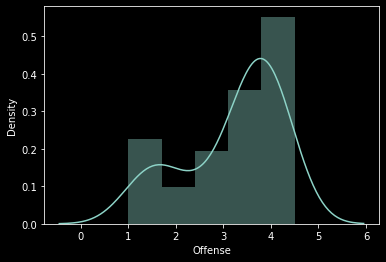

In [ ]:
# ▶ Offense : 공격력, 캐릭터가 얼마나 많은 데미지를 입힐 수 있는지
sns.distplot(df['Offense']);

In [ ]:
# df[df['Offense'] == df['Offense'].max()]
df[df['Offense'] == df['Offense'].min()]

,Name,Description,Role,Ranged_or_Melee,UsageDifficulty,Offense,Endurance,Mobility,Scoring,Support
20,Wigglytuff,Wigglytuff learns lots of moves that can stop ...,Supporter,Ranged,Intermediate,1.0,2.5,2.5,2.0,4.5
37,Blissey,Blissey is a Pokémon that excels at supporting...,Supporter,Melee,Novice,1.0,3.5,1.5,1.5,4.5


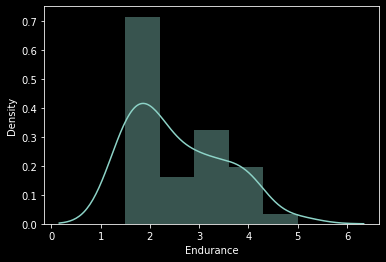

In [ ]:
# ▶ Endurance : 지구력, 캐릭터의 HP와 체력 재생력
sns.distplot(df['Endurance']);

In [ ]:
#df[df['Endurance'] == df['Endurance'].max()]
df[df['Endurance'] == df['Endurance'].min()]

,Name,Description,Role,Ranged_or_Melee,UsageDifficulty,Offense,Endurance,Mobility,Scoring,Support
0,Zoroark,Confound the competition with Zoroark’s speed ...,Speedster,Melee,Expert,3.5,1.5,4.0,2.0,0.5
5,Delphox,Add a Ranged Attacker to your team with this f...,Attacker,Ranged,Novice,4.0,1.5,3.0,2.5,0.5
16,Alolan Ninetales,Alolan Ninetales uses moves that freeze its op...,Attacker,Ranged,Intermediate,4.0,1.5,1.5,2.5,3.0
17,Cinderace,Cinderace doesn’t just have high attack power—...,Attacker,Ranged,Novice,4.0,1.5,3.0,2.5,0.5
28,Talonflame,Talonflame toys with the opposing team by usin...,Speedster,Melee,Novice,2.5,1.5,5.0,3.5,0.5
34,Pikachu,Pikachu is a Pokémon that excels at attacking ...,Attacker,Ranged,Novice,4.5,1.5,2.5,2.0,1.5
35,Zeraora,Zeraora can close the distance between itself ...,Speedster,Melee,Expert,3.5,1.5,4.0,3.0,0.5
36,Gardevoir,Gardevoir strikes its opponents from far away ...,Attacker,Ranged,Intermediate,4.5,1.5,1.5,3.0,1.5
39,Sylveon,Sylveon attacks opponents from a distance whil...,Attacker,Ranged,Intermediate,3.5,1.5,1.5,3.5,3.5
41,Greedent,Stash away or consume Berries strategically to...,Defender,Melee,Expert,4.0,1.5,2.0,1.0,1.0


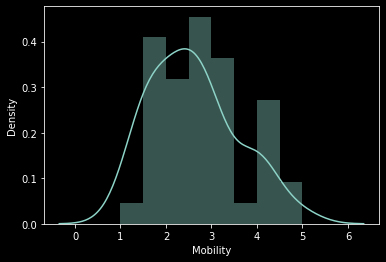

In [ ]:
# ▶ Mobility : 기동성, 빠른 공격
sns.distplot(df['Mobility']);

In [ ]:
#df[df['Mobility'] == df['Mobility'].max()]
df[df['Mobility'] == df['Mobility'].min()]

,Name,Description,Role,Ranged_or_Melee,UsageDifficulty,Offense,Endurance,Mobility,Scoring,Support
25,Mr. Mime,Mr. Mime specializes in hindering opposing Pok...,Supporter,Melee,Intermediate,1.5,4.0,1.0,1.5,4.0


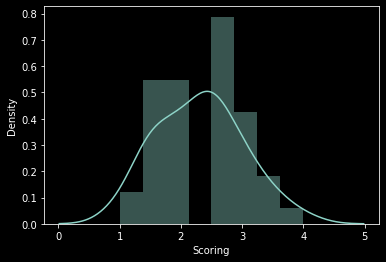

In [ ]:
# ▶ Scoring : 득점력, 얼마나 득점하기 쉬운지 나타내는 스테이터스 (※ 팀의 최종 득점으로 승패를 결정함)
sns.distplot(df['Scoring']);

In [ ]:
#df[df['Scoring'] == df['Scoring'].max()]
df[df['Scoring'] == df['Scoring'].min()]

,Name,Description,Role,Ranged_or_Melee,UsageDifficulty,Offense,Endurance,Mobility,Scoring,Support
2,Glaceon,Take the Glacial Stage with this sleet-footed ...,Attacker,Ranged,Intermediate,4.0,2.0,3.0,1.0,0.5
41,Greedent,Stash away or consume Berries strategically to...,Defender,Melee,Expert,4.0,1.5,2.0,1.0,1.0


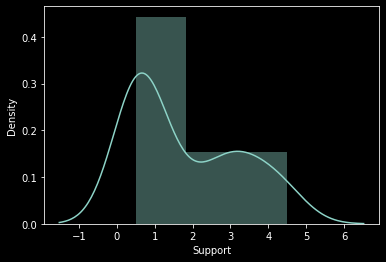

In [ ]:
# ▶ Support : 지원 등급, 다른 캐릭터를 지원할 수 있는 등급, 높으면 Support의 성격이 큰 캐릭터
sns.distplot(df['Support']);

In [ ]:
#df[df['Support'] == df['Support'].max()]
df[df['Support'] == df['Support'].min()]

,Name,Description,Role,Ranged_or_Melee,UsageDifficulty,Offense,Endurance,Mobility,Scoring,Support
0,Zoroark,Confound the competition with Zoroark’s speed ...,Speedster,Melee,Expert,3.5,1.5,4.0,2.0,0.5
2,Glaceon,Take the Glacial Stage with this sleet-footed ...,Attacker,Ranged,Intermediate,4.0,2.0,3.0,1.0,0.5
4,Dodrio,Prove that three heads are better than one wit...,Speedster,Melee,Expert,3.0,2.0,4.0,4.0,0.5
5,Delphox,Add a Ranged Attacker to your team with this f...,Attacker,Ranged,Novice,4.0,1.5,3.0,2.5,0.5
11,Duraludon,Add a Ranged Attacker to your UNITE team with ...,Attacker,Ranged,Intermediate,3.5,3.5,2.5,2.5,0.5
12,Azumarill,Add a Melee All-Rounder to your team with a wh...,All-Rounder,Melee,Novice,3.0,3.0,2.5,2.5,0.5
13,Tsareena,"Tsareena is ready to glide, kick, and stomp it...",All-Rounder,Melee,Expert,3.5,3.0,3.0,1.5,0.5
14,Dragonite,Dragonite is ready to rampage through the comp...,All-Rounder,Melee,Novice,4.0,2.5,2.5,3.0,0.5
17,Cinderace,Cinderace doesn’t just have high attack power—...,Attacker,Ranged,Novice,4.0,1.5,3.0,2.5,0.5
18,Garchomp,"Garchomp’s Ability, Rough Skin, means it can s...",All-Rounder,Melee,Intermediate,3.5,3.5,2.5,2.5,0.5


### · Role에 다른 스테이터스 분포 확인
---

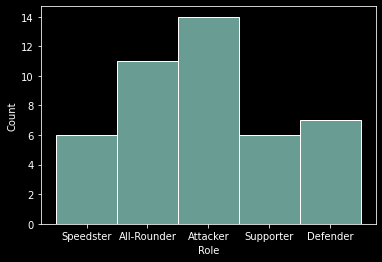

In [ ]:
sns.histplot(data = df['Role'], kde = False);

In [ ]:
df["Role"].value_counts()

Attacker       14
All-Rounder    11
Defender        7
Speedster       6
Supporter       6
Name: Role, dtype: int64

6


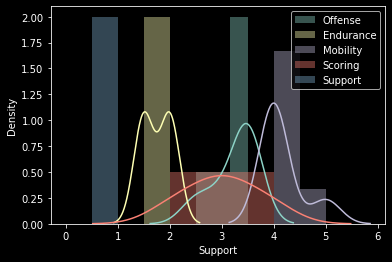

In [ ]:
# ▶ (1) Speedster : 기동력이 빠른 type의 캐릭터
plt.style.use(['dark_background'])


df_speed = df[df['Role'] == 'Speedster']
print(len(df_speed))

sns.distplot(df_speed['Offense'], label = 'Offense');
sns.distplot(df_speed['Endurance'], label = 'Endurance');
sns.distplot(df_speed['Mobility'], label = 'Mobility');
sns.distplot(df_speed['Scoring'], label = 'Scoring');
sns.distplot(df_speed['Support'], label = 'Support');
plt.legend();

In [ ]:
df1 = pd.DataFrame(df[['Offense', 'Endurance', 'Mobility', 'Scoring','Support']].mean(), columns=['Total'])
df2 = pd.DataFrame(df_speed[['Offense', 'Endurance', 'Mobility', 'Scoring','Support']].mean(), columns=['speed'])
df3 = pd.concat([df1,df2], axis=1)
df3['gap'] = df3['speed'] - df3['Total']
df3

,Total,speed,gap
Offense,3.204545,3.250000,0.045455
Endurance,2.545455,1.750000,-0.795455
Mobility,2.602273,4.166667,1.564394
Scoring,2.306818,3.000000,0.693182
Support,1.784091,0.500000,-1.284091


6


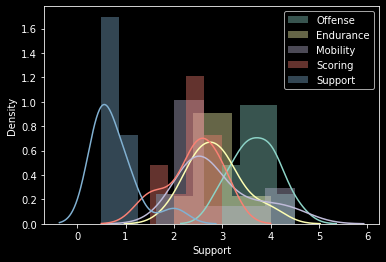

In [ ]:
# ▶ (2) All-Rounder : 만능 캐릭터
plt.style.use(['dark_background'])


df_all = df[df['Role'] == 'All-Rounder']
print(len(df_speed))

sns.distplot(df_all['Offense'], label = 'Offense');
sns.distplot(df_all['Endurance'], label = 'Endurance');
sns.distplot(df_all['Mobility'], label = 'Mobility');
sns.distplot(df_all['Scoring'], label = 'Scoring');
sns.distplot(df_all['Support'], label = 'Support');
plt.legend();

In [ ]:
df1 = pd.DataFrame(df[['Offense', 'Endurance', 'Mobility', 'Scoring','Support']].mean(), columns=['Total'])
df2 = pd.DataFrame(df_all[['Offense', 'Endurance', 'Mobility', 'Scoring','Support']].mean(), columns=['select'])
df3 = pd.concat([df1,df2], axis=1)
df3['gap'] = df3['select'] - df3['Total']
df3

,Total,select,gap
Offense,3.204545,3.681818,0.477273
Endurance,2.545455,2.863636,0.318182
Mobility,2.602273,2.909091,0.306818
Scoring,2.306818,2.409091,0.102273
Support,1.784091,0.772727,-1.011364


14


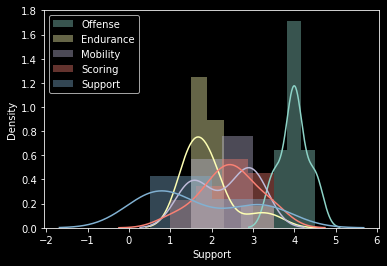

In [ ]:
# ▶ (3) Attacker Role : 공격 특화 캐릭터
plt.style.use(['dark_background'])


df_attack = df[df['Role'] == 'Attacker']
print(len(df_attack))

sns.distplot(df_attack['Offense'], label = 'Offense');
sns.distplot(df_attack['Endurance'], label = 'Endurance');
sns.distplot(df_attack['Mobility'], label = 'Mobility');
sns.distplot(df_attack['Scoring'], label = 'Scoring');
sns.distplot(df_attack['Support'], label = 'Support');
plt.legend();

In [ ]:
df1 = pd.DataFrame(df[['Offense', 'Endurance', 'Mobility', 'Scoring','Support']].mean(), columns=['Total'])
df2 = pd.DataFrame(df_attack[['Offense', 'Endurance', 'Mobility', 'Scoring','Support']].mean(), columns=['select'])
df3 = pd.concat([df1,df2], axis=1)
df3['gap'] = df3['select'] - df3['Total']
df3

,Total,select,gap
Offense,3.204545,4.000000,0.795455
Endurance,2.545455,1.928571,-0.616883
Mobility,2.602273,2.321429,-0.280844
Scoring,2.306818,2.428571,0.121753
Support,1.784091,1.678571,-0.105519


6


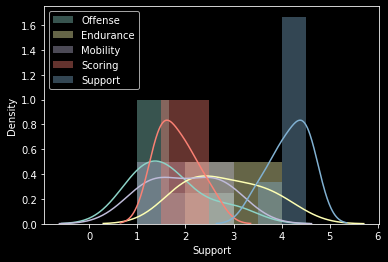

In [ ]:
# ▶ (4) Supporter Role : 지원 특화
plt.style.use(['dark_background'])


df_spport = df[df['Role'] == 'Supporter']
print(len(df_spport))

sns.distplot(df_spport['Offense'], label = 'Offense');
sns.distplot(df_spport['Endurance'], label = 'Endurance');
sns.distplot(df_spport['Mobility'], label = 'Mobility');
sns.distplot(df_spport['Scoring'], label = 'Scoring');
sns.distplot(df_spport['Support'], label = 'Support');
plt.legend();

In [ ]:
df1 = pd.DataFrame(df[['Offense', 'Endurance', 'Mobility', 'Scoring','Support']].mean(), columns=['Total'])
df2 = pd.DataFrame(df_spport[['Offense', 'Endurance', 'Mobility', 'Scoring','Support']].mean(), columns=['select'])
df3 = pd.concat([df1,df2], axis=1)
df3['gap'] = df3['select'] - df3['Total']
df3

,Total,select,gap
Offense,3.204545,1.666667,-1.537879
Endurance,2.545455,2.833333,0.287879
Mobility,2.602273,2.000000,-0.602273
Scoring,2.306818,1.833333,-0.473485
Support,1.784091,4.166667,2.382576


7


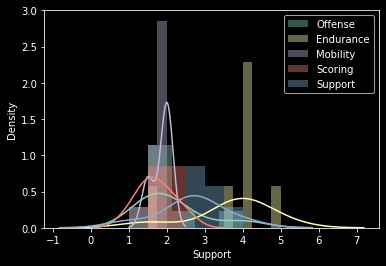

In [ ]:
# ▶ (5) Defender Role : 방어특화
plt.style.use(['dark_background'])


df_dfense = df[df['Role'] == 'Defender']
print(len(df_dfense))

sns.distplot(df_dfense['Offense'], label = 'Offense');
sns.distplot(df_dfense['Endurance'], label = 'Endurance');
sns.distplot(df_dfense['Mobility'], label = 'Mobility');
sns.distplot(df_dfense['Scoring'], label = 'Scoring');
sns.distplot(df_dfense['Support'], label = 'Support');
plt.legend();

In [ ]:
df1 = pd.DataFrame(df[['Offense', 'Endurance', 'Mobility', 'Scoring','Support']].mean(), columns=['Total'])
df2 = pd.DataFrame(df_dfense[['Offense', 'Endurance', 'Mobility', 'Scoring','Support']].mean(), columns=['select'])
df3 = pd.concat([df1,df2], axis=1)
df3['gap'] = df3['select'] - df3['Total']
df3

,Total,select,gap
Offense,3.204545,2.142857,-1.061688
Endurance,2.545455,3.714286,1.168831
Mobility,2.602273,1.857143,-0.745130
Scoring,2.306818,1.714286,-0.592532
Support,1.784091,2.642857,0.858766


In [ ]:
list(df['Role'].unique())

['Speedster', 'All-Rounder', 'Attacker', 'Supporter', 'Defender']

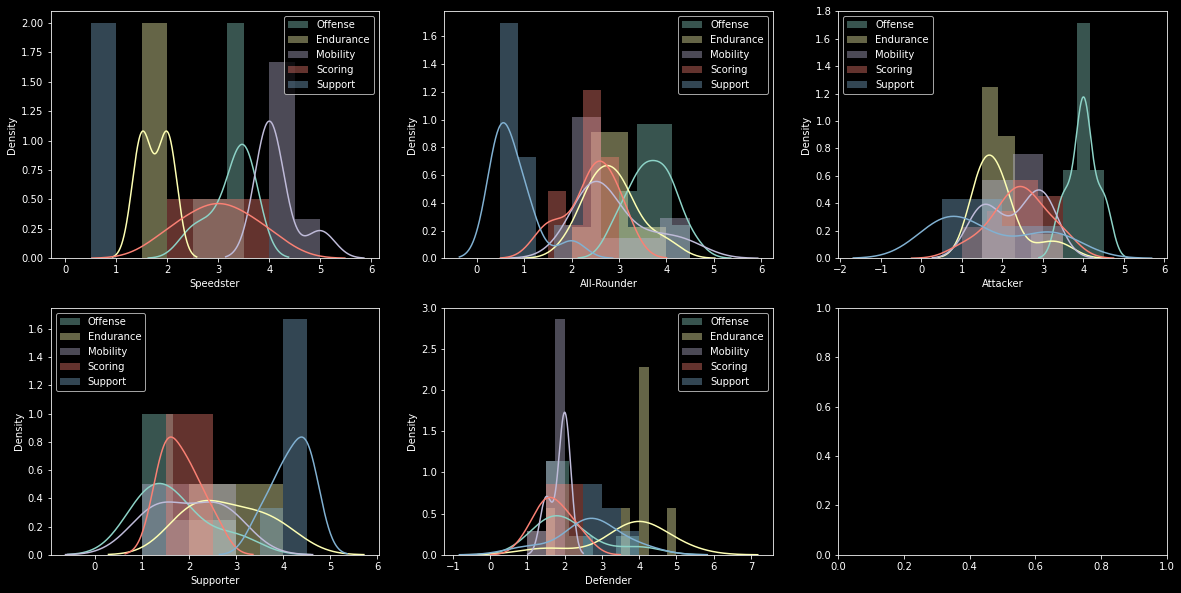

In [ ]:
col_n = 3
row_n = 2

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20,row_n*5))

for i,col in enumerate(list(df['Role'].unique())):

  df_val = df[df['Role'] == col]

  sns.distplot(df_val['Offense'], label = 'Offense', ax=ax[int(i/col_n),int(i%col_n)]);
  sns.distplot(df_val['Endurance'], label = 'Endurance', ax=ax[int(i/col_n),int(i%col_n)]);
  sns.distplot(df_val['Mobility'], label = 'Mobility', ax=ax[int(i/col_n),int(i%col_n)]);
  sns.distplot(df_val['Scoring'], label = 'Scoring', ax=ax[int(i/col_n),int(i%col_n)]);
  sns.distplot(df_val['Support'], label = 'Support', ax=ax[int(i/col_n),int(i%col_n)]);
  ax[int(i/col_n),int(i%col_n)].set_xlabel(col)
  ax[int(i/col_n),int(i%col_n)].legend();

### · Rader(Spider) Chart
---

In [ ]:
df_rader = df[['Name', 'Offense',	'Endurance',	'Mobility',	'Scoring',	'Support']]
df_rader = df_rader.head(2)
df_rader

,Name,Offense,Endurance,Mobility,Scoring,Support
0,Zoroark,3.5,1.5,4.0,2.0,0.5
1,Scizor,4.5,2.5,4.5,2.5,1.0


In [ ]:
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
plt.style.use(['default'])

def rader_chart(df_rader) :

  ## 하나로 합치기
  labels = df_rader.columns[1:]
  num_labels = len(labels)

  angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
  angles += angles[:1] ## 시작점으로 다시 돌아와야하므로 시작점 추가

  my_palette = plt.cm.get_cmap("Set2", len(df_rader.index))

  fig = plt.figure(figsize=(4,4))
  fig.set_facecolor('white')
  ax = fig.add_subplot(polar=True)
  for i, row in df_rader.iterrows():
      color = my_palette(i)
      data = df_rader.iloc[i].drop('Name').tolist()
      data += data[:1]

      ax.set_theta_offset(pi / 2) ## 시작점
      ax.set_theta_direction(-1) ## 그려지는 방향 시계방향

      plt.xticks(angles[:-1], labels, fontsize=10) ## 각도 축 눈금 라벨
      ax.tick_params(axis='x', which='major', pad=10) ## 각 축과 눈금 사이에 여백을 준다.

      ax.set_rlabel_position(0) ## 반지름 축 눈금 라벨 각도 설정(degree 단위)
      plt.yticks([0,2,4,5],['0','2','4','5'], fontsize=8) ## 반지름 축 눈금 설정
      plt.ylim(0,5)

      ax.plot(angles, data, color=color, linewidth=1, linestyle='solid', label=row.Name) ## 레이더 차트 출력
      ax.fill(angles, data, color=color, alpha=0.2) ## 도형 안쪽에 색을 채워준다.

  plt.legend(loc=(0.9,0.9))
  plt.show()

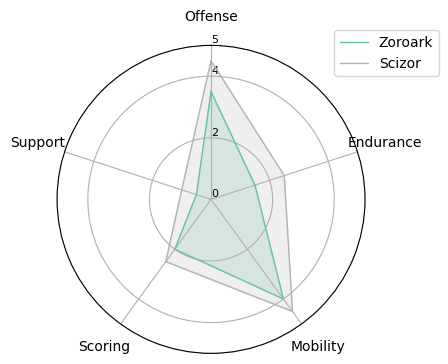

In [ ]:
rader_chart(df_rader)

## **🥇Session 3**  
**┗ 이상 탐지 모델링**  
---

### · All-status abnormal Character
---

In [ ]:
df.head()

,Name,Description,Role,Ranged_or_Melee,UsageDifficulty,Offense,Endurance,Mobility,Scoring,Support
0,Zoroark,Confound the competition with Zoroark’s speed ...,Speedster,Melee,Expert,3.5,1.5,4.0,2.0,0.5
1,Scizor,Test your mettle with this Melee All-Rounder c...,All-Rounder,Melee,Intermediate,4.5,2.5,4.5,2.5,1.0
2,Glaceon,Take the Glacial Stage with this sleet-footed ...,Attacker,Ranged,Intermediate,4.0,2.0,3.0,1.0,0.5
3,Tyranitar,Go on a rampage with this tyrannical Melee All...,All-Rounder,Melee,Intermediate,4.0,4.0,2.0,1.5,1.0
4,Dodrio,Prove that three heads are better than one wit...,Speedster,Melee,Expert,3.0,2.0,4.0,4.0,0.5


In [ ]:
# ▶ (1) 총 합이 다른 캐릭터 존재 유무
df['all_stat'] = df['Offense'] + df['Endurance'] + df['Mobility'] + df['Scoring'] + df['Support']

In [ ]:
df['all_stat'].value_counts()

12.5    21
12.0     6
11.5     5
13.5     5
13.0     3
15.0     1
10.5     1
14.0     1
9.5      1
Name: all_stat, dtype: int64

In [ ]:
df_allstat = pd.DataFrame(df['all_stat'].value_counts()).reset_index()
df_allstat.columns = ['all_stat', 'cnt']
df_allstat

,all_stat,cnt
0,12.5,21
1,12.0,6
2,11.5,5
3,13.5,5
4,13.0,3
5,15.0,1
6,10.5,1
7,14.0,1
8,9.5,1


In [ ]:
# ▶ All stat이 다른 캐릭터가 존재함
df_allstat.sort_values(by=['all_stat'], ascending = False)

,all_stat,cnt
5,15.0,1
7,14.0,1
3,13.5,5
4,13.0,3
0,12.5,21
1,12.0,6
2,11.5,5
6,10.5,1
8,9.5,1


In [ ]:
# ▶ 15.0 vs 9.5
df[(df['all_stat']==15) | (df['all_stat']==9.5) | (df['all_stat']==14) |(df['all_stat']==10.5)]

,Name,Description,Role,Ranged_or_Melee,UsageDifficulty,Offense,Endurance,Mobility,Scoring,Support,all_stat
1,Scizor,Test your mettle with this Melee All-Rounder c...,All-Rounder,Melee,Intermediate,4.5,2.5,4.5,2.5,1.0,15.0
2,Glaceon,Take the Glacial Stage with this sleet-footed ...,Attacker,Ranged,Intermediate,4.0,2.0,3.0,1.0,0.5,10.5
9,Mew,Psych out the competition with this trickster ...,Attacker,Ranged,Novice,4.0,2.0,3.0,2.0,3.0,14.0
41,Greedent,Stash away or consume Berries strategically to...,Defender,Melee,Expert,4.0,1.5,2.0,1.0,1.0,9.5


In [ ]:
# ▶ Rader chart 비교
df_rader = df[(df['all_stat']==15) | (df['all_stat']==9.5)][['Name', 'Offense',	'Endurance',	'Mobility',	'Scoring',	'Support']].reset_index(drop=True)
df_rader2 = df[(df['all_stat']==9.5) |(df['all_stat']==10.5)][['Name', 'Offense',	'Endurance',	'Mobility',	'Scoring',	'Support']].reset_index(drop=True)
df_rader

,Name,Offense,Endurance,Mobility,Scoring,Support
0,Scizor,4.5,2.5,4.5,2.5,1.0
1,Greedent,4.0,1.5,2.0,1.0,1.0


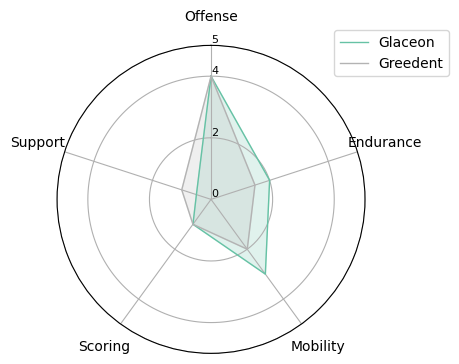

In [ ]:
rader_chart(df_rader2)

### · All-status abnormal Character by Role
---

In [ ]:
df.head()

,Name,Description,Role,Ranged_or_Melee,UsageDifficulty,Offense,Endurance,Mobility,Scoring,Support,all_stat
0,Zoroark,Confound the competition with Zoroark’s speed ...,Speedster,Melee,Expert,3.5,1.5,4.0,2.0,0.5,11.5
1,Scizor,Test your mettle with this Melee All-Rounder c...,All-Rounder,Melee,Intermediate,4.5,2.5,4.5,2.5,1.0,15.0
2,Glaceon,Take the Glacial Stage with this sleet-footed ...,Attacker,Ranged,Intermediate,4.0,2.0,3.0,1.0,0.5,10.5
3,Tyranitar,Go on a rampage with this tyrannical Melee All...,All-Rounder,Melee,Intermediate,4.0,4.0,2.0,1.5,1.0,12.5
4,Dodrio,Prove that three heads are better than one wit...,Speedster,Melee,Expert,3.0,2.0,4.0,4.0,0.5,13.5


In [ ]:
# ▶ Role에 따른 All-stat 비교
df_all_stat_role = pd.DataFrame(df.groupby(['Role','all_stat'])['Name'].count()).reset_index()
df_all_stat_role.sort_values(['Role', 'all_stat'], ascending= [True, False])

,Role,all_stat,Name
3,All-Rounder,15.0,1
2,All-Rounder,13.5,1
1,All-Rounder,12.5,7
0,All-Rounder,11.5,2
9,Attacker,14.0,1
8,Attacker,13.5,2
7,Attacker,12.5,5
6,Attacker,12.0,3
5,Attacker,11.5,2
4,Attacker,10.5,1


In [ ]:
# ▶ Role별 min stat
df_min = pd.DataFrame(df_all_stat_role.groupby('Role')['all_stat'].min())
df_min

,all_stat
Role,
All-Rounder,11.5
Attacker,10.5
Defender,9.5
Speedster,11.5
Supporter,12.0


In [ ]:
# ▶ Role별 max stat
df_max = pd.DataFrame(df_all_stat_role.groupby('Role')['all_stat'].max())
df_max

,all_stat
Role,
All-Rounder,15.0
Attacker,14.0
Defender,13.0
Speedster,13.5
Supporter,13.5


In [ ]:
# ▶ Concat data
df_merge = pd.concat([df_max, df_min],axis=1).reset_index()
df_merge.columns = ['Role', 'max', 'min']
df_merge['gap'] = df_merge['max'] - df_merge['min']
df_merge

,Role,max,min,gap
0,All-Rounder,15.0,11.5,3.5
1,Attacker,14.0,10.5,3.5
2,Defender,13.0,9.5,3.5
3,Speedster,13.5,11.5,2.0
4,Supporter,13.5,12.0,1.5


In [ ]:
# ▶ Rader chart 비교 (All-Rounder)
df_rader = df[((df['all_stat']==15) | (df['all_stat']==11.5)) & (df['Role'] == 'All-Rounder')][['Name', 'Offense',	'Endurance',	'Mobility',	'Scoring',	'Support']].reset_index(drop=True)
df_rader

,Name,Offense,Endurance,Mobility,Scoring,Support
0,Scizor,4.5,2.5,4.5,2.5,1.0
1,Azumarill,3.0,3.0,2.5,2.5,0.5
2,Tsareena,3.5,3.0,3.0,1.5,0.5


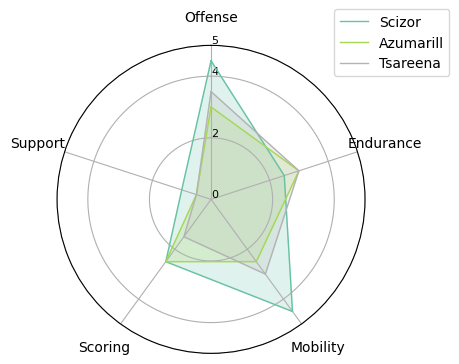

In [ ]:
rader_chart(df_rader)

In [ ]:
# ▶ Rader chart 비교 (Attacker)
df_rader = df[(df['all_stat']==14.0) | (df['all_stat']==10.5) & (df['Role'] == 'Attacker')][['Name', 'Offense',	'Endurance',	'Mobility',	'Scoring',	'Support']].reset_index(drop=True)
df_rader

,Name,Offense,Endurance,Mobility,Scoring,Support
0,Glaceon,4.0,2.0,3.0,1.0,0.5
1,Mew,4.0,2.0,3.0,2.0,3.0


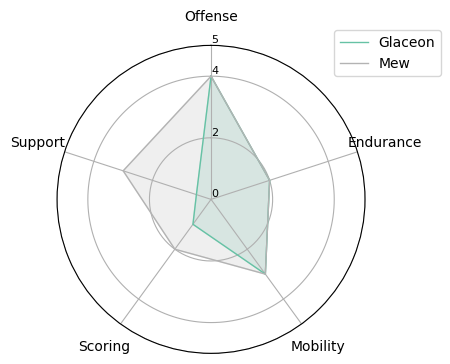

In [ ]:
rader_chart(df_rader)

In [ ]:
# ▶ Rader chart 비교 (Defender)
df_rader = df[(df['all_stat']==13.0) | (df['all_stat']==9.5) & (df['Role'] == 'Defender')][['Name', 'Offense',	'Endurance',	'Mobility',	'Scoring',	'Support']].reset_index(drop=True)
df_rader

,Name,Offense,Endurance,Mobility,Scoring,Support
0,Trevenant,2.0,4.0,2.0,2.5,2.5
1,Gengar,3.5,2.0,4.0,3.0,0.5
2,Talonflame,2.5,1.5,5.0,3.5,0.5
3,Greedent,4.0,1.5,2.0,1.0,1.0


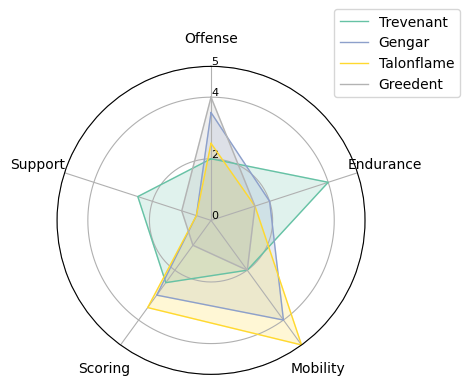

In [ ]:
rader_chart(df_rader.iloc[1,3])